In [1]:
# #library pengolahan data
import pandas as pd
import numpy as np

import os
import sys

# #Library visualisasi data audio dan tabular
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# #Library membangun model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# #Library review audio
from IPython.display import Audio

# #Llibrary tensorflow model framework
import tensorflow
import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Data Prepratation

In [2]:
Tess = '/Users/itdeveloper/AI Workspace/Course/MLT2-sound-recognition_SR4/TESS_dataset/'
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# #buat dataframe untuk data file_emotion
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# #dataframe untuk file path
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...
1,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...
2,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...
3,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...
4,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...


In [3]:
data_path = pd.concat([ Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...
1,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...
2,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...
3,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...
4,disgust,/Users/itdeveloper/AI Workspace/Course/MLT2-so...


# Explolratory Data dan Visualisasi Data

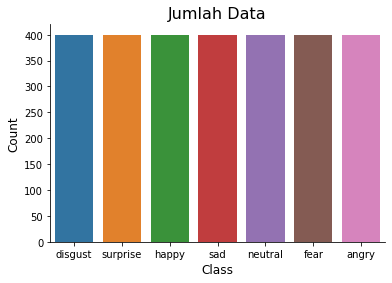

In [4]:
plt.title('Jumlah Data', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Class', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [5]:
Tess_df.shape

(2800, 2)

### Plotting sinyal audio

#### Waveplot memberi informasi kenyaringan audio pada waktu tertentu
#### Spektogram memberi informasi visualisasi spektrum frekuensi suara atau sinyal lain yang berubah berdasarkan waktu. Merepresentasi frekuensi yang berubah sehubungan dengan waktu untuk sinyal audio/musik

In [6]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveshow class {}'.format(e), size=15)
    librosa.display.waveshow(data, sr = sr )
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram class {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

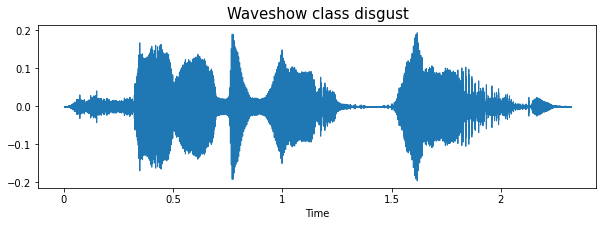

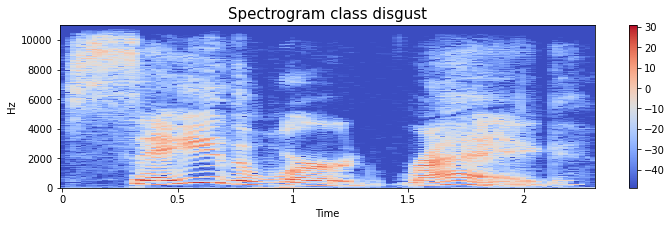

In [7]:
emotion='disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

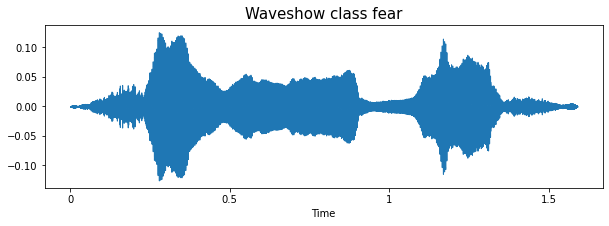

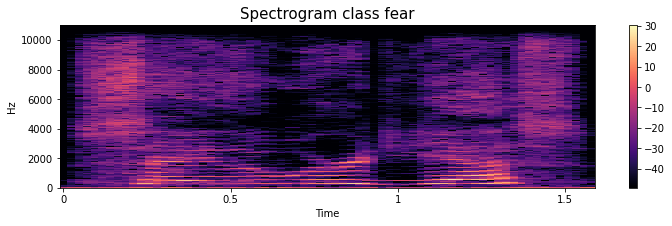

In [8]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

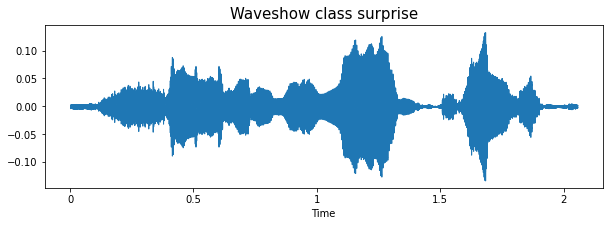

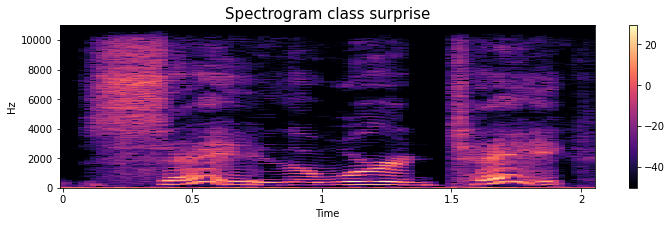

In [9]:
emotion='surprise'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

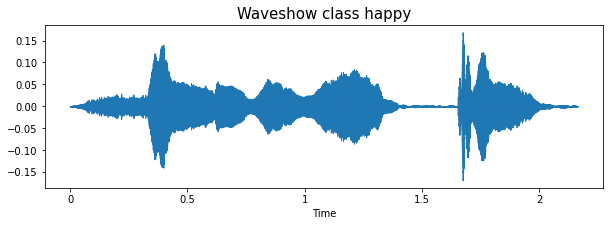

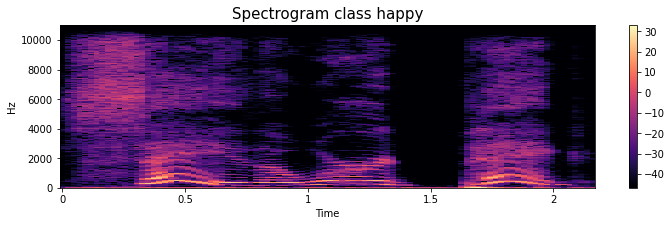

In [10]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentasi
Membuat data baru ke dataset training, untuk menangani dataset yang sedikit

Menghasilkan tambahan data audio dengan menerapkan noise, shifting time, dan change pitch and speed

Untuk membuat model menjadi invarian dan meningkatkan kemampuan generalisasi data

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

### Original Audio

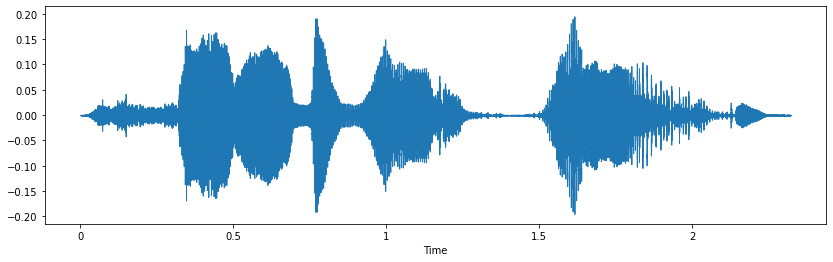

In [12]:
# mengambil 1 row data untuk melihat hasil dari augmentasi
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

### Penerapan Noise Injection

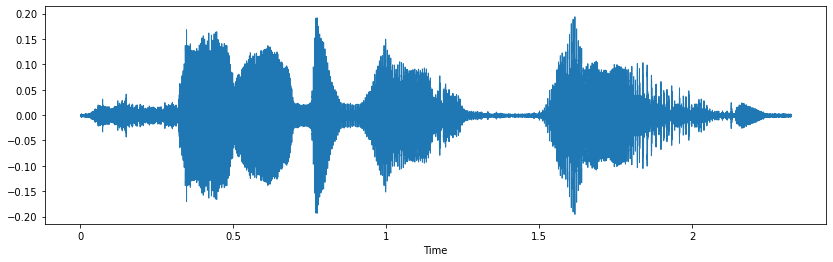

In [13]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Hasil noise injection dari teknik augmentasi terlihat ketika di detik ke 1 sampai 1.5, teknik ini agar dapat memastikan model pelatihan tidak overfitted

### Penerapan Strecthing

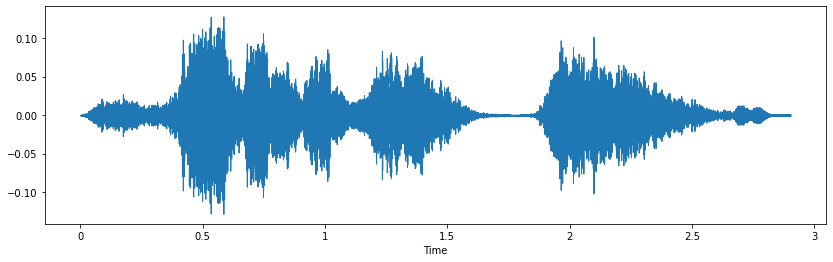

In [14]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Penerapan Shifting

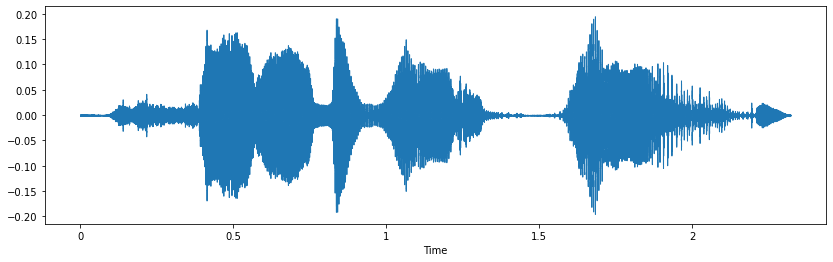

In [15]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Penerapan Pitch

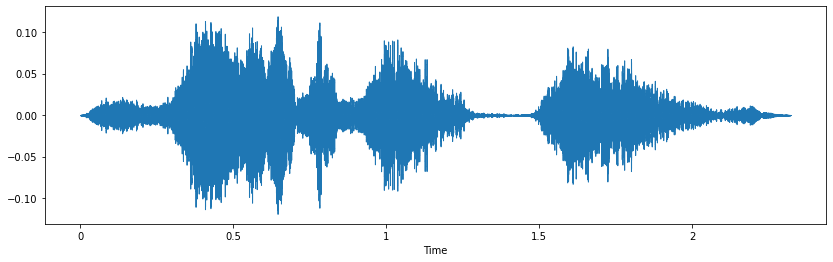

In [16]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

Feature extraction untuk menganalisa dan menemukan hubungan antar data. Komputer tidak dapat mengenali data audio dan harus diubah formatnya agar bisa dimengerti untuk di ekstrak fiturnya.

Sinyal audio ada tiga dimensi, dimana dimensi tersebut mewakili waktu, amplitudo, dan frekuensi

Terdapat beberapa teknik feature extraction untuk data audio.
referensi: https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225

1. Zero Crossing Rate : Tingkat perubahan tanda sinyal selama durasi frame tertentu

2. Energi : Jumlah kuadrat dari nilai sinyal, dinormalisasi dengan panjang frame masing2

3. Entrophy : Entrophy yang dinormalisasi dapat diartikan sebagai ukuran perubahan mendadak

4. Spectral Centroid : Pusat Gravitasi energi spektral yang dinormalisasi untuk satu set sub-frame.

5. Spectral Spread : Momen sentral kedua dari spektrum.

6. Entropi Spektral : Entropi energi spektral yang dinormalisasi untuk satu set sub-frame.

7. Fluks Spektral : Selisih kuadrat antara besaran spektrum yang dinormalisasi dari dua bingkai yang berurutan.

8. Spectral Rolloff : Frekuensi di bawah 90% dari distribusi magnitudo spektrum terkonsentrasi.

9. MFCCs Mel Frequency Cepstral Coefficients membentuk representasi cepstral di mana pita frekuensi tidak linier tetapi didistribusikan menurut skala mel.

10. Chroma Vector : Representasi 12-elemen dari energi spektral di mana bin mewakili 12 kelas nada yang sama dari musik tipe barat (spasi semitone).

11. Chroma Deviation : Standar deviasi dari 12 koefisien chroma.

In [17]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # durasi dan offset digunakan untuk menjaga tidak ada audio di awal dan akhir setiap file audio seperti yang terlihat di atas.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # tanpa augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [18]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        #append data dengan data augmentasi
        Y.append(emotion)

In [19]:
#Cek shape data
len(X), len(Y), data_path.Path.shape

(8400, 8400, (2800,))

Menerapkan augmentasi data pada setiap data dan save ke features.csv

In [20]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.134721,0.546444,0.536142,0.530184,0.583434,0.590913,0.632633,0.647343,0.654843,0.581108,...,0.000171,0.000182,0.000164,0.000145,0.000090,0.000050,0.000009,9.003712e-07,1.351818e-08,disgust
1,0.250038,0.601522,0.627181,0.641324,0.683506,0.704527,0.708145,0.698602,0.718957,0.648566,...,0.000349,0.000355,0.000342,0.000328,0.000277,0.000232,0.000188,1.754339e-04,1.762398e-04,disgust
2,0.186895,0.602704,0.543554,0.542957,0.487581,0.511708,0.535257,0.624772,0.661976,0.670731,...,0.000066,0.000041,0.000039,0.000035,0.000032,0.000016,0.000003,1.767893e-07,1.864959e-09,disgust
3,0.072734,0.564552,0.515326,0.504785,0.498699,0.516803,0.552634,0.618640,0.626435,0.601062,...,0.000079,0.000070,0.000083,0.000062,0.000033,0.000017,0.000007,8.470521e-07,3.816526e-08,disgust
4,0.159030,0.596441,0.572746,0.576398,0.582324,0.615390,0.627904,0.655824,0.652735,0.648370,...,0.000300,0.000301,0.000299,0.000276,0.000261,0.000239,0.000233,2.230931e-04,2.331270e-04,disgust


# Data Preparation

Melakukan normalisasi data untuk training data

In [21]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

Untuk masalah klasifikasi multiclass, menggunakan encode pakai OneHotEncoding

In [22]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [23]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [24]:
#melakukan scaling pakai sklearn standar scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [25]:
#buat dimensi baru dengan jumlah n class emosi, agar compatible terhadap model
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162, 1), (6300, 7), (2100, 162, 1), (2100, 7))

In [26]:
x_train.shape

(6300, 162, 1)

# Modeling

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 153, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 144, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 128)            163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                    

2022-07-26 14:04:35.266671: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
197/197 [==============================] - 8s 36ms/step - loss: 1.7226 - accuracy: 0.4252 - val_loss: 0.7349 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 2/50
197/197 [==============================] - 7s 36ms/step - loss: 0.7119 - accuracy: 0.8151 - val_loss: 0.3989 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 3/50
197/197 [==============================] - 8s 41ms/step - loss: 0.4961 - accuracy: 0.8852 - val_loss: 0.3104 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 4/50
197/197 [==============================] - 7s 35ms/step - loss: 0.4528 - accuracy: 0.9029 - val_loss: 0.3008 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 5/50
197/197 [==============================] - 7s 34ms/step - loss: 0.3832 - accuracy: 0.9257 - val_loss: 0.2409 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 6/50
197/197 [==============================] - 6s 33ms/step - loss: 0.3550 - accuracy: 0.9314 - val_loss: 0.2722 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 7/50
197/197 [==============================] - 6s 33ms/st

66/66 [==============================] - 1s 9ms/step - loss: 0.0553 - accuracy: 0.9924
Akurasi model terhadap data test :  99.23809766769409 %


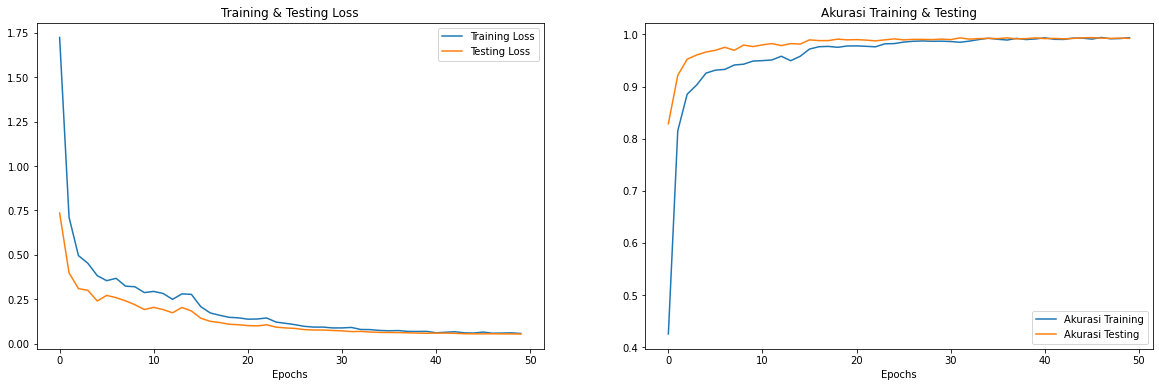

In [29]:
#Visualisasi Hasil Traning
print("Akurasi model terhadap data test : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Akurasi Training')
ax[1].plot(epochs , test_acc , label = 'Akurasi Testing')
ax[1].set_title('Akurasi Training & Testing')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [30]:
# prediksi terhadap test data
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [31]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,neutral,neutral
2,happy,happy
3,sad,sad
4,neutral,neutral
5,fear,fear
6,fear,fear
7,fear,fear
8,surprise,surprise
9,fear,fear


# Evaluasi Model Confusion Matrix

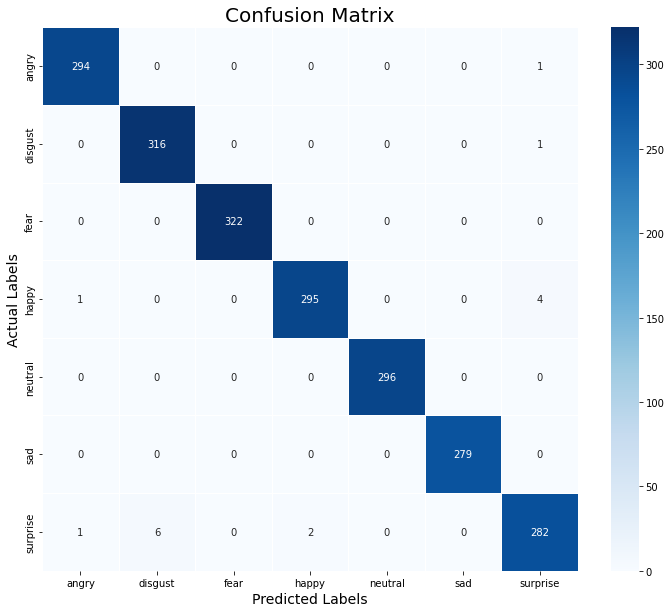

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.99      1.00      0.99       295
     disgust       0.98      1.00      0.99       317
        fear       1.00      1.00      1.00       322
       happy       0.99      0.98      0.99       300
     neutral       1.00      1.00      1.00       296
         sad       1.00      1.00      1.00       279
    surprise       0.98      0.97      0.97       291

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100



In [34]:
model.save("sound_model_tess.h5")

# Kesimpulan
Model dengan 3 layer dengan masing masing Maxpooling dan Dropout dengan serta teknik Augmentasi dapat mengenali 7 class emosi dengan optimizer Adam, learning rate 0.001, ReduceLRPlateu, batch size 32 dan epoch sebanyak 50 mendapatkan akurasi 99%.